## Import packages and set up plot defaults

In [1]:
using CoordinatedPrecoding, OptimalBaseStationClustering
using PyPlot, LaTeXStrings

PyPlot.rc("lines", linewidth=1., markersize=3, markeredgewidth=0.5)
PyPlot.rc("font", size=8, family="serif", serif="Computer Modern Sans Serif")
PyPlot.rc("text", usetex=true)
PyPlot.rc("text.latex", preamble="\\usepackage{amsmath}")
PyPlot.rc("axes", linewidth=0.5, labelsize=8)
PyPlot.rc("xtick", labelsize=8)
PyPlot.rc("ytick", labelsize=8)
PyPlot.rc("legend", fancybox=true, fontsize=8)
PyPlot.rc("figure", figsize=(3.50,3.50), dpi=125)

## Multicell scenario definition

In [2]:
num_cells = 12; num_MSs_per_cell = 2
num_BS_antennas = 8; num_MS_antennas = 2; num_streams = 1
geography_width = 1500.; MS_serving_distance = 150.
num_coherence_symbols = 2_700
SNR_dB = 30

srand(3991233)
simulation_params = Dict(
    "simulation_name" => "convergence",
    "I" => num_cells, "Kc" => num_MSs_per_cell, "M" => num_BS_antennas, "N" => num_MS_antennas, "d" => num_streams,
    "Ndrops" => 1,
    "geography_size" => (geography_width, geography_width),
    "MS_serving_BS_distance" => Nullable(MS_serving_distance),
    "aux_network_params" => Dict(
        "num_coherence_symbols" => 2_700,
    ),
)

# Generate network
network =
    setup_random_large_scale_network(num_cells, num_MSs_per_cell, num_MS_antennas, num_BS_antennas,
        num_streams=num_streams, geography_size=(geography_width, geography_width),
        MS_serving_BS_distance=Nullable(MS_serving_distance))
set_average_SNRs_dB!(network, SNR_dB)

## Utility definition

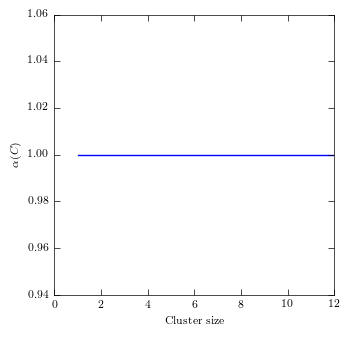

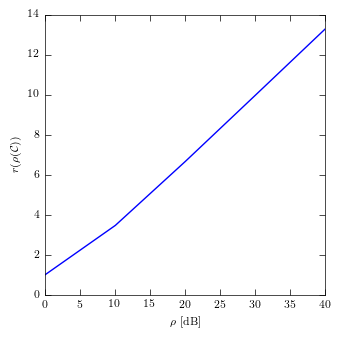

PyObject <matplotlib.text.Text object at 0x3192f3210>

In [3]:
# Throughput
α(C) = 1.
r(ρ) = log2(1 + ρ)
t(C, ρ) = α(C)*r(ρ)

# Max cluster size
D = floor(Int, (num_BS_antennas + num_MS_antennas - num_streams)/(num_MSs_per_cell*num_streams))

# System-level objective
f(ts) = sum(ts)

# Plot in two dimensions
vals_alpha = 1:num_cells; utils_alpha = [ α(C) for C in vals_alpha ]
vals_rho = 10.^(0:40/10); utils_rho = [ r(ρ) for ρ in vals_rho ]
fig = PyPlot.figure(); ax = fig[:add_axes]((0.15,0.15,0.95-0.15,0.95-0.15))
ax[:plot](vals_alpha, utils_alpha); ax[:set_xlabel]("Cluster size"); ax[:set_ylabel](L"$\alpha(C)$")
fig = PyPlot.figure(); ax = fig[:add_axes]((0.15,0.15,0.95-0.15,0.95-0.15))
ax[:plot](10*log10(vals_rho), utils_rho); ax[:set_xlabel](L"$\rho$ [dB]"); ax[:set_ylabel](L"$r(\rho(\mathcal{C}))$")

### Create specialized branch and bound method

In [4]:
simulation_params["aux_assignment_params"] =
    Dict("GeneralBranchAndBoundClustering:branching_rule" => :bfs,
         "GeneralBranchAndBoundClustering:max_abs_optimality_gap" => 0.,
         "GeneralBranchAndBoundClustering:max_rel_optimality_gap" => 0.,
         "GeneralBranchAndBoundClustering:store_evolution" => true)
BranchAndBoundClustering(channel, network) = GeneralBranchAndBoundClustering(channel, network, f, t, D)
GreedyClustering(channel, network) = GeneralGreedyClustering(channel, network, f, t, D)
simulation_params["assignment_methods"] = [ BranchAndBoundClustering, GreedyClustering ];

### Simulate

In [5]:
raw_results = simulate_assignment_convergence(network, simulation_params);

-- simulate_assignment_convergence on RandomLargeScaleNetwork(I = 12, Kc = 2, geography_size = (1500.0,1500.0), MS_serving_BS_distance = Nullable(150.0)).
--- Ndrops: 1.
2015-09-29T17:59:28 - info: Starting convergence simulation. network:RandomLargeScaleNetwork(I = 12, Kc = 2, geography_size = (1500.0,1500.0), MS_serving_BS_distance = Nullable(150.0)) simulation_params:Dict{ASCIIString,Any}("Ndrops"=>1,"M"=>8,"N"=>2,"MS_serving_BS_distance"=>Nullable(150.0),"aux_assignment_params"=>Dict{ASCIIString,Any}("GeneralBranchAndBoundClustering:store_evolution"=>true,"GeneralBranchAndBoundClustering:max_abs_optimality_gap"=>0.0,"GeneralBranchAndBoundClustering:branching_rule"=>:bfs,"GeneralBranchAndBoundClustering:max_rel_optimality_gap"=>0.0),"assignment_methods"=>[BranchAndBoundClustering,GreedyClustering],"d"=>1,"geography_size"=>(1500.0,1500.0),"aux_network_params"=>Dict("num_coherence_symbols"=>2700),"simulation_name"=>"convergence","I"=>12,"Kc"=>2)
2015-09-29T17:59:32 - info: GeneralGree

### Visualize generated cluster

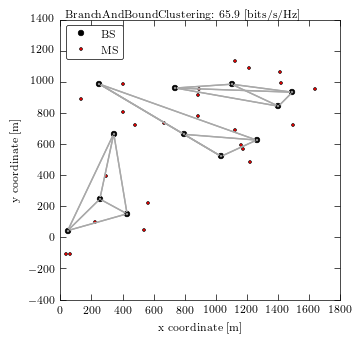

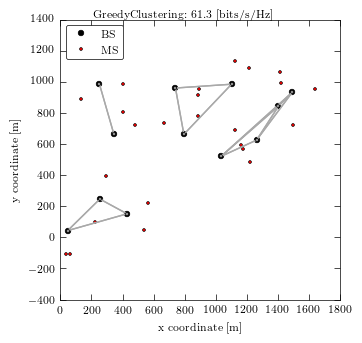

In [6]:
for method in [:BranchAndBoundClustering, :GreedyClustering]
    a = raw_results.simulation_results[1].precoding_results[string(method)]["a"]
    objective = f(raw_results.simulation_results[1].precoding_results[string(method)]["throughputs"])
    partition = Partition(a)
    
    fig = PyPlot.figure()
    ax = fig[:add_axes]((0.15,0.15,0.95-0.15,0.95-0.15))

    # BSs
    global line_BS
    for i = 1:num_cells
        pos = network.BSs[i].position
        line_BS = ax[:plot](pos.x, pos.y; marker="o", color="k", markersize=4, linewidth=0, label="BS")
    end

    # MSs
    global line_MS
    for k = 1:num_cells*num_MSs_per_cell
        pos = network.MSs[k].position
        line_MS = ax[:plot](pos.x, pos.y; marker="o", color="r", markersize=2, linewidth=0, label="MS")
    end

    # Annotations
    ax[:set_xlabel]("x coordinate [m]")
    ax[:set_ylabel]("y coordinate [m]")
    legend = ax[:legend](handles=[line_BS[1], line_MS[1]], loc="upper left", numpoints=1)
    legend_frame = legend[:get_frame]()
    PyPlot.setp(legend_frame, linewidth=0.5)
    
    # Square plot
    ax[:set_aspect]("equal", "datalim")

    # Save without cluster lines
    if method == :CoalitionFormationClustering_AttachOrSupplant
        fig[:savefig]("network_layout_example.eps")
    end

    # Show cluster lines
    for block in partition.blocks
        for i in block.elements
            for j in block.elements
                if i == j; continue; end
                pos1 = network.BSs[i].position; pos2 = network.BSs[j].position
                ax[:plot]([pos1.x, pos2.x], [pos1.y, pos2.y]; marker="o", color="DarkGray", markersize=2)
            end
        end
    end

    title = @sprintf "%s: %.1f [bits/s/Hz]" string(method) objective
    fig[:suptitle](replace(title, "_", "-"))
    display(fig)
end

### Visualize convergence

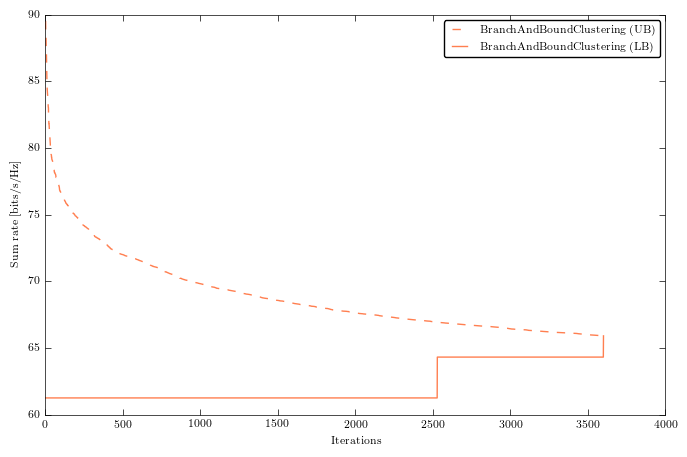

2015-09-29T17:59:36 - info: GeneralGreedyClustering finished. objective:61.26701961271955 a:[0,1,2,3,2,1,3,2,0,3,0,0]
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


In [7]:
plot_params_bounds = Dict(
    "plot_name" => "bounds",

    "objective" => :none,

    "figure" => Dict(
        :figsize => (8,5),
        :dpi => 125,
    ),

    "axes" => Dict(
        :xlabel => "Iterations",
        :ylabel => "Sum rate [bits/s/Hz]",
    ),

    "legend" => Dict(
        :loc => "best",
    ),

    "methods" => Dict(
        "BranchAndBoundClustering" => [
            ("upper_bound_evolution", Dict(:color => "Coral", :linestyle => "--", :label => "BranchAndBoundClustering (UB)")),
            ("lower_bound_evolution", Dict(:color => "Coral", :linestyle => "-", :label => "BranchAndBoundClustering (LB)")),
        ],
    )
)
processed_results = postprocess_assignment_convergence(raw_results, simulation_params, plot_params_bounds)
plot_assignment_convergence(processed_results, simulation_params, plot_params_bounds, user_plots=false)